In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from time import time
from mpl_toolkits.mplot3d import Axes3D
import math
import os
from matplotlib import cm

In [7]:
from classes.mesh import Mesh
from classes.NeuralNet import PINN_NeuralNet
from classes.PINN import PINN

In [8]:
class PDE_Model():

    def __init__(self):

        self.DTYPE='float32'
        self.pi = tf.constant(np.pi, dtype=self.DTYPE)
   
    def set_domain(self,X):
        x,y = X
        self.xmin = x[0]
        self.xmax = x[1]
        self.ymin = y[0]
        self.ymax = y[1]

        lb = tf.constant([self.xmin, self.ymin], dtype=self.DTYPE)
        ub = tf.constant([self.xmax, self.ymax], dtype=self.DTYPE)

        return (lb,ub)

    # Define boundary condition
    def fun_u_b(self,x, y, value):
        n = x.shape[0]
        return tf.ones((n,1), dtype=self.DTYPE)*value

    def fun_ux_b(self,x, y, value):
        n = x.shape[0]
        return tf.ones((n,1), dtype=self.DTYPE)*value

    def rhs(self,r,o):
        #res = (1/(0.04*(2*self.pi)**0.5))*tf.exp((-1/(2*0.04**2))*((r*tf.cos(o))**2+(r*tf.sin(o))**2))
        res = -1
        return res

    # Define residual of the PDE
    def fun_r(self,r,o,u_r,u_rr,u_o):
        return u_rr*r*r + u_r*r + u_o + 1 #self.rhs(r,o)
        

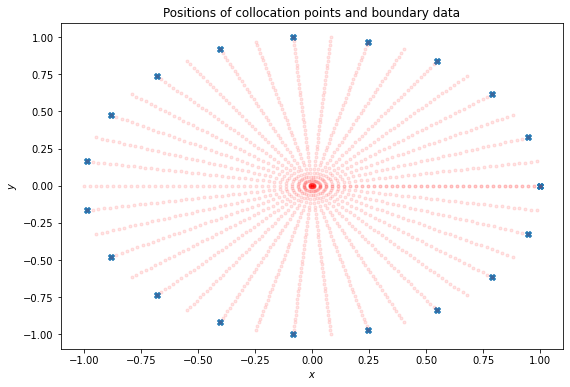

In [13]:
domain = ([0.01,1],[0,2*math.pi])
PDE = PDE_Model()
domain = PDE.set_domain(domain)

lb = {'type':'D', 'value':0, 'fun':None, 'dr':None, 'r':1}

borders = {'1':lb}

mesh = Mesh(domain, N_b=20, N_r=1500)
mesh.create_mesh(borders)
mesh.plot_points();



PINN_solver = PINN()
PINN_solver.adapt_mesh(mesh)
PINN_solver.adapt_PDE(PDE)
PINN_solver.create_NeuralNet(PINN_NeuralNet)




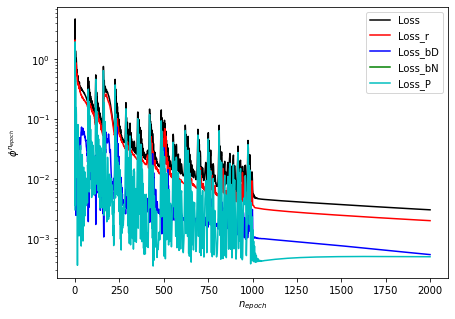

In [14]:
PINN_solver.solve(N=2000,flag_time=False)
PINN_solver.plot_loss_history();

In [15]:
print(os.getcwd())

c:\Users\achom\OneDrive - Universidad Técnica Federico Santa María\Materias\4. Computación Científica\6. Physics Neural Network\Code


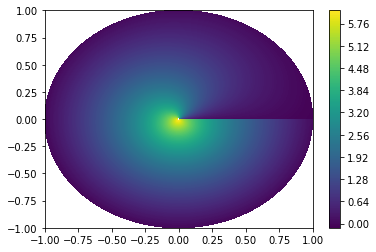

In [11]:
r,o,u = PINN_solver.get_u()
x = r*np.cos(o)
y = r*np.sin(o)
plt.contourf(x,y,u,400)
plt.colorbar();

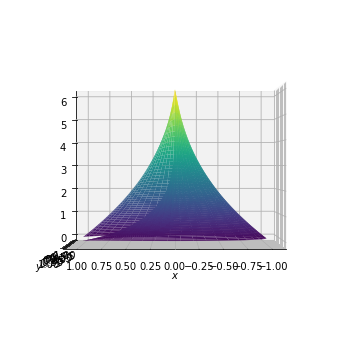

In [12]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, u, cmap='viridis');
ax.view_init(0,90)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

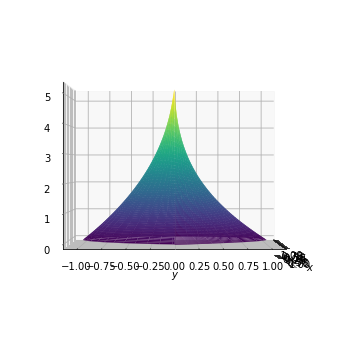

In [10]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, u, cmap='viridis');
ax.view_init(0,0)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

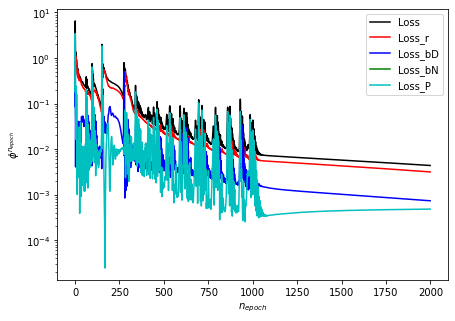

In [162]:
PINN_solver.plot_loss_history();

In [152]:
class PDE_Model2():

    def __init__(self):

        self.DTYPE='float32'
        self.pi = tf.constant(np.pi, dtype=self.DTYPE)
   
    def set_domain(self,X):
        x,y = X
        self.xmin = x[0]
        self.xmax = x[1]
        self.ymin = y[0]
        self.ymax = y[1]

        lb = tf.constant([self.xmin, self.ymin], dtype=self.DTYPE)
        ub = tf.constant([self.xmax, self.ymax], dtype=self.DTYPE)

        return (lb,ub)

    # Define boundary condition
    def fun_u_b(self,x, y, value):
        n = x.shape[0]
        return tf.ones((n,1), dtype=self.DTYPE)*value

    def fun_ux_b(self,x, y, value):
        n = x.shape[0]
        return tf.ones((n,1), dtype=self.DTYPE)*value

    # Define residual of the PDE
    def fun_r(self,x,y,u_x,u_xx,u_yy):
        return u_xx*x*x + u_x*x + u_yy

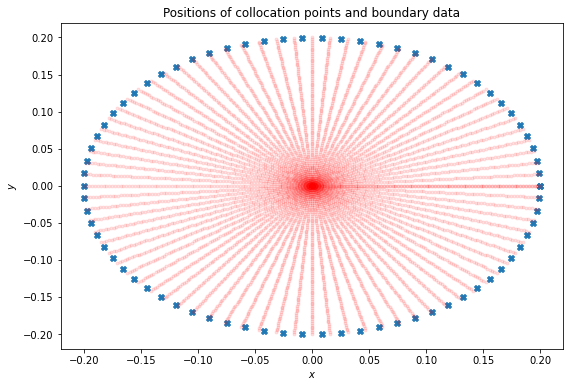

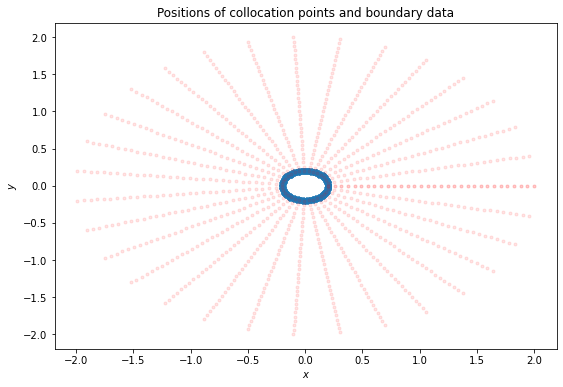

In [164]:
domain = ([0.001,0.2],[0,2*math.pi])
PDE1 = PDE_Model()
domain = PDE1.set_domain(domain)

lb = {'type':'I', 'value':None, 'fun':None, 'dr':None,'r':0.2}
borders = {'1':lb}
mesh1 = Mesh(domain, N_b=300, N_r=80**2)
mesh1.create_mesh(borders)
mesh1.plot_points();

domain = ([0.2,2],[0,2*math.pi])
PDE2 = PDE_Model2()
domain = PDE2.set_domain(domain)

Ib = {'type':'I', 'value':None, 'fun':None, 'dr':None, 'r':0.2}
#lb = {'type':'D', 'value':0, 'fun':None, 'dr':None,'r':8}
borders = dict()
borders['1'] = Ib
mesh2 = Mesh(domain, N_b=300, N_r=1000)
mesh2.create_mesh(borders)
mesh2.plot_points();

conds = (1,10)


In [165]:
res = mesh2.X_r

In [166]:
#solverx = XPINN(PINN_NeuralNet,(mesh1,mesh2),(PDE1,PDE2),conds)

In [167]:
solverx.solve(N=2000, flag_time=False)

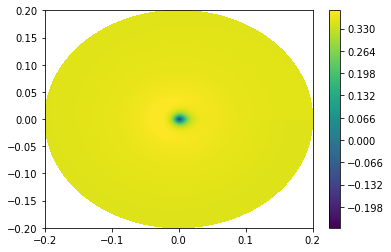

In [168]:
p1,p2 = solverx.get_u()
r,o,u1 = p1
x1 = r*np.cos(o)
y1 = r*np.sin(o)

r,o,u2 = p2
x2 = r*np.cos(o)
y2 = r*np.sin(o)

plt.contourf(x1,y1,u1,400)
plt.colorbar();



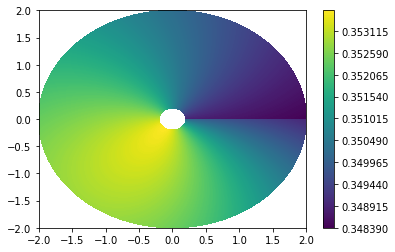

In [169]:
plt.contourf(x2,y2,u2,400)
plt.colorbar();

Text(0.5, 0, '$u_\\theta(t,x)$')

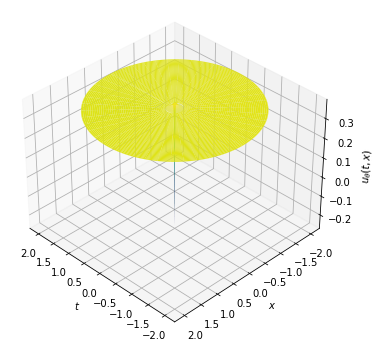

In [170]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')

max_v = np.max(np.array([np.max(u1),np.max(u2)]))
min_v = np.min(np.array([np.min(u1),np.min(u2)]))

ax.plot_surface(x1, y1, u1, cmap=cm.viridis, vmin=min_v, vmax=max_v);
ax.plot_surface(x2, y2, u2,  cmap=cm.viridis, vmin=min_v, vmax=max_v);

ax.view_init(35,135)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u_\\theta(t,x)$')

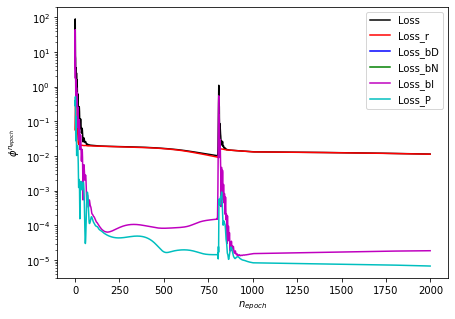

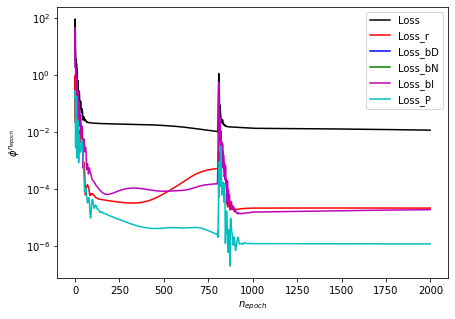

In [171]:
solverx.plot_loss_history1();
solverx.plot_loss_history2();